# Telecom customer churn prediction

# Project goal:

Using information about the telecom operator clients build the ML model that will predict customer churn.

# Data description

The operator provides two main types of services:

1. Fixed telephone connection.
2. Internet. The connection can be of two types: via a telephone line DSL or fiber optic cable.

Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic check are available.

- `contract.csv` — contract info;
- `personal.csv` — clients personal data;
- `internet.csv` — info about internet services;
- `phone.csv` — info about phone services.

# Project planning

- Import data, do the initial data preparation (missing values, outliers, etc.)
- Data preprocessing
    - Check duplicates
    - Check missing values
- - Understand nature of the data. Check distributions and correlations
- Model training
    - Classic ML: logistic regression, random forest
    - CatBoostClassifier
- Comparing the models
    - Compare AUC ROC 
    - Compare Accuracy
    - Compare speed of the models
- Conclusion
    - Best model results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection\
import train_test_split, TimeSeriesSplit, cross_validate, PredefinedSplit, GridSearchCV

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
contract = pd.read_csv('C:/datasets/final_provider/contract.csv')
internet = pd.read_csv('C:/datasets/final_provider/internet.csv')
personal = pd.read_csv('C:/datasets/final_provider/personal.csv')
phone = pd.read_csv('C:/datasets/final_provider/phone.csv')

# Data preprocessing

## Missing values and duplicates check

In [3]:
print('Dataframe size:')
print('contract:', contract.shape)
print('internet:', internet.shape)
print('personal:', personal.shape)
print('phone:', phone.shape)

Dataframe size:
contract: (7043, 8)
internet: (5517, 8)
personal: (7043, 5)
phone: (6361, 2)


The number of users doesn't match across different dataframes. Thus the information about some of the clients might not be sufficient.

UPD: if the user is not in the table, then they don't use this service

**contract**

In [4]:
def basic_analysis(df):
    # prints basic info about the dataframe and checks for duplicates
    print(df.info())
    print()
    print(df.describe())
    print()
    print('Duplicating rows:', contract.duplicated().any())

In [5]:
def unique_check(df, cols):
    # prints unique values in passed columns of the df
    print('Unique values in the selected columns:')
    print()
    for col in cols:
        print(col, ':', df[col].unique())

In [6]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [7]:
basic_analysis(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

Duplicating rows: False


- Dates and total_charges are object type. Should fix it

In [8]:
contract["customerID"].duplicated().any()

False

In [9]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [10]:
contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [11]:
contract['EndDate'].replace('No', np.nan, inplace=True)
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

If the customer has a date in the EndDate column than they stopped using the telecom services.

I will use this knowledge to extract the target variable:\
1 if client has left, 0 otherwise

In [12]:
def left_status(enddate):
    if pd.isnull(enddate) is True:
        return 0
    else:
        return 1

In [13]:
# target column
contract['Left'] = contract['EndDate'].apply(func=left_status)

In [14]:
unique_check(contract, ['Type', 'PaperlessBilling','PaymentMethod'])

Unique values in the selected columns:

Type : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [15]:
#replace missing value with np.nan
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', np.nan)

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Left              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


- Data types are correct now
- No duplicates in the categorical varibales or customer ids were found
- Found some missing values in "TotalCharges" simply marked by space.

In [17]:
contract[contract["TotalCharges"].isna()]

customerID  BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01     NaT  Two year              Yes   
753   3115-CZMZD 2020-02-01     NaT  Two year               No   
936   5709-LVOEQ 2020-02-01     NaT  Two year               No   
1082  4367-NUYAO 2020-02-01     NaT  Two year               No   
1340  1371-DWPAZ 2020-02-01     NaT  Two year               No   
3331  7644-OMVMY 2020-02-01     NaT  Two year               No   
3826  3213-VVOLG 2020-02-01     NaT  Two year               No   
4380  2520-SGTTA 2020-02-01     NaT  Two year               No   
5218  2923-ARZLG 2020-02-01     NaT  One year              Yes   
6670  4075-WKNIU 2020-02-01     NaT  Two year               No   
6754  2775-SEFEE 2020-02-01     NaT  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Left  
488   Bank transfer (automatic)           52.55           NaN     0  
753                Mailed check           20.25           NaN     0  
936                Mailed check           80.85           NaN     0  
1082               Mailed check           25.75           NaN     0  
1340    Credit card (automatic)           56.05           NaN     0  
3331               Mailed check           19.85           NaN     0  
3826               Mailed check           25.35           NaN     0  
4380               Mailed check           20.00           NaN     0  
5218               Mailed check           19.70           NaN     0  
6670               Mailed check           73.35           NaN     0  
6754  Bank transfer (automatic)           61.90           NaN     0

Clients with missing TotalCharges are people that just recently started using the Telecom services.\
2020-02-01 is the date of data export.\
It would be best to delete these users as they won't be useful for this project anyway.

In [18]:
# clients with missing payment info
no_pay_clients = list(contract[contract["TotalCharges"].isna()]['customerID'])

contract.dropna(subset=['TotalCharges'], inplace=True)
contract.shape

(7032, 9)

**personal**

In [19]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [20]:
basic_analysis(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

Duplicating rows: False


In [21]:
contract["customerID"].duplicated().any()

False

In [22]:
print(personal['gender'].unique())
print(personal['SeniorCitizen'].unique())
print(personal['Partner'].unique())
print(personal['Dependents'].unique())

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


Everything seems to be all right with the data. Proceeding forward

**internet**

In [23]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [24]:
basic_analysis(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV Streami

In [25]:
internet["customerID"].duplicated().any()

False

In [26]:
unique_check(internet, list(internet.columns[1:]))

Unique values in the selected columns:

InternetService : ['DSL' 'Fiber optic']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']


**phone**

In [27]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [28]:
basic_analysis(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

Duplicating rows: False


In [29]:
unique_check(phone, ['MultipleLines'])

Unique values in the selected columns:

MultipleLines : ['No' 'Yes']


Duplicates and missing values checked.

All datasets are ready for further analysis.

## Merge the tables

In [30]:
print('Dataframe size:')
print('contract:', contract.shape)
print('internet:', internet.shape)
print('personal:', personal.shape)
print('phone:', phone.shape)

Dataframe size:
contract: (7032, 9)
internet: (5517, 8)
personal: (7043, 5)
phone: (6361, 2)


In [31]:
df = personal.merge(contract, on='customerID')
df = df.merge(internet, on='customerID', how='outer')
df = df.merge(phone, on='customerID', how='outer')

In [32]:
# drop the no_pay_clients
df = df.loc[~df['customerID'].isin(no_pay_clients)]

In [33]:
df.shape

(7032, 21)

In [34]:
basic_analysis(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   float64       
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  Left              7032 non-null   float64       
 13  InternetService   5512 non-null   object        
 14  OnlineSecurity    5512 n

All tables combined into one dataframe

## Process missing values

The missing values are concentrated in categorical features that describe whether the client uses a particular service.

I will replace these values by negative answers. That is if the client does not use the Internet then StreamingTV feature would also be set to "No".

In [35]:
# categorical features
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod',
               'Left', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [36]:
df[cat_features] = df[cat_features].fillna(value='No')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   float64       
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  Left              7032 non-null   float64       
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

# EDA

## Categorical features

In [38]:
# returns unique values from the col and the number of times these values are found in the df
def label_size(df, col):
    labels = list(df[col].unique())
    sizes = []
    for i in labels:
        sizes.append(df.loc[df[col] == i][col].count())
    return labels, sizes

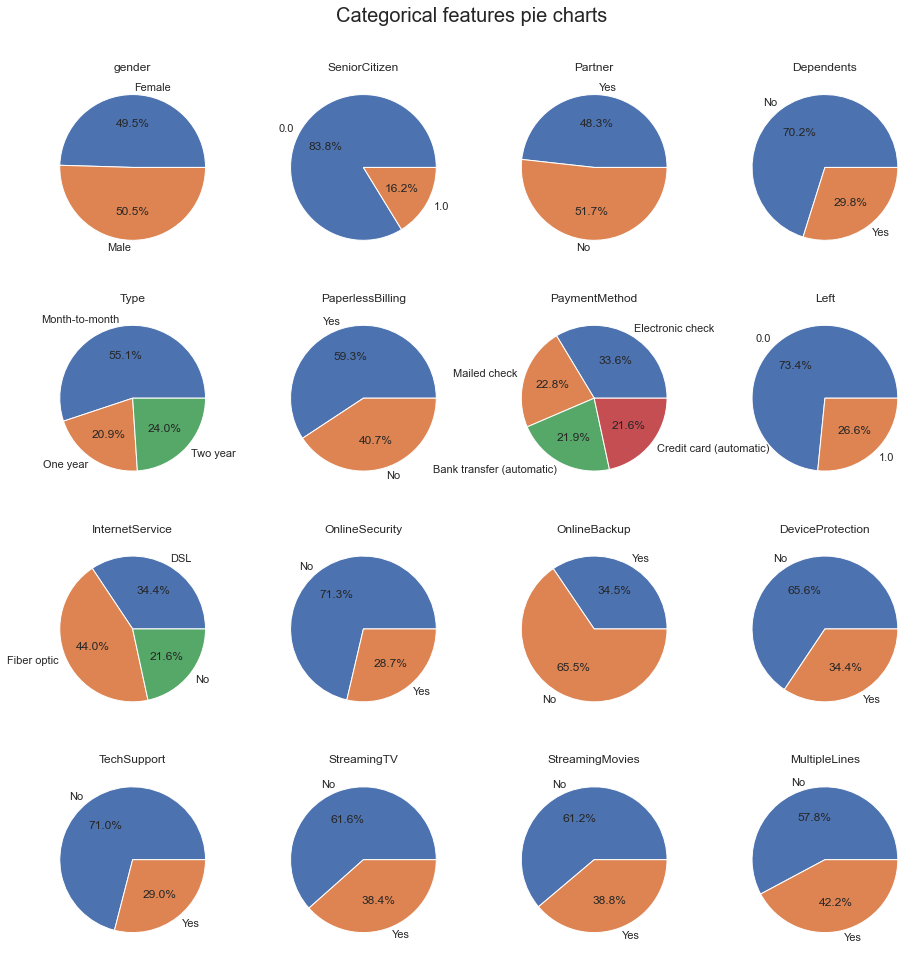

In [39]:
fig, axs = plt.subplots(4,4, figsize = (13,13))
plt.tight_layout()

count = -1
for i in range(4):
    for x in range(4):
        count+=1
        col = cat_features[count]
        axs[i,x].pie(x=label_size(df, col)[1],
                     labels=label_size(df, col)[0], 
                     autopct='%1.1f%%',)
        axs[i,x].title.set_text(str(col))

plt.suptitle('Categorical features pie charts', fontsize=20, y=1.05)
plt.show()

- The sample is balanced by gender and partner features.
- 16.2% of people are senior citizens 
- near a quarter of users have left the operator
- Nothing odd about the sample overall, I consider it to be balanced, thus the ML models shouldn't overfit on any of those.

Let's check influence of these factors on the target variable.

I will use chi-square test from sklearn library

In [40]:
# caregorical features without the target variable
cat_df = df[cat_features].drop('Left', axis=1)

In [41]:
enc = OrdinalEncoder()

In [42]:
data_ordinal = pd.DataFrame(enc.fit_transform(cat_df), columns=cat_df.columns)

In [43]:
data_ordinal.head()

gender  SeniorCitizen  Partner  Dependents  Type  PaperlessBilling  \
0     0.0            0.0      1.0         0.0   0.0               1.0   
1     1.0            0.0      0.0         0.0   1.0               0.0   
2     1.0            0.0      0.0         0.0   0.0               1.0   
3     1.0            0.0      0.0         0.0   1.0               0.0   
4     0.0            0.0      0.0         0.0   0.0               1.0   

   PaymentMethod  InternetService  OnlineSecurity  OnlineBackup  \
0            2.0              0.0             0.0           1.0   
1            3.0              0.0             1.0           0.0   
2            3.0              0.0             1.0           1.0   
3            0.0              0.0             1.0           0.0   
4            2.0              1.0             0.0           0.0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  MultipleLines  
0               0.0          0.0          0.0              0.0            0.0  
1               1.0          0.0          0.0              0.0            0.0  
2               0.0          0.0          0.0              0.0            0.0  
3               1.0          1.0          0.0              0.0            0.0  
4               0.0          0.0          0.0              0.0            0.0

In [44]:
x=data_ordinal  #Independent variable
y=df['Left']   #Target variable
f_score=chi2(x,y)   #returns f score and p value 

In [45]:
# prints p values for each categorical feature
p_value=pd.Series(f_score[1],index=x.columns)
p_value.sort_values(ascending=True,inplace=True)

In [46]:
alpha = 0.05
for i in range(len(p_value)):
    if p_value[i] < alpha:
        print('Feature', p_value.index[i], ': Reject the null hypothesis. Feature influences the target variable')
    else:
        print()
        print(p_value.index[i], ": Can't reject the null hypothesis. Feature might not have influence on the target variable")

Feature Type : Reject the null hypothesis. Feature influences the target variable
Feature OnlineSecurity : Reject the null hypothesis. Feature influences the target variable
Feature TechSupport : Reject the null hypothesis. Feature influences the target variable
Feature SeniorCitizen : Reject the null hypothesis. Feature influences the target variable
Feature Dependents : Reject the null hypothesis. Feature influences the target variable
Feature PaperlessBilling : Reject the null hypothesis. Feature influences the target variable
Feature Partner : Reject the null hypothesis. Feature influences the target variable
Feature PaymentMethod : Reject the null hypothesis. Feature influences the target variable
Feature OnlineBackup : Reject the null hypothesis. Feature influences the target variable
Feature DeviceProtection : Reject the null hypothesis. Feature influences the target variable
Feature StreamingTV : Reject the null hypothesis. Feature influences the target variable
Feature Streami

Gender feature by itself might not ahve influence on the target variable, thus could be dropped and not used for the model training.

However as it might have influence in a couple with other feature, I will double check this feature importance after the model is trained. 

## Numeric data

**MonthlyCharges**

In [47]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

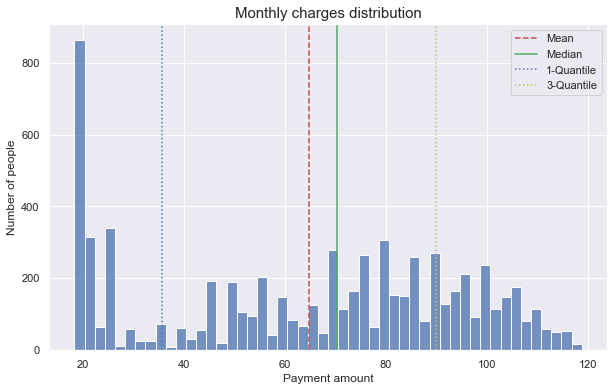

In [48]:
mean = df['MonthlyCharges'].mean()
median = df['MonthlyCharges'].median()
Q1 = df['MonthlyCharges'].quantile(q=0.25)
Q3 = df['MonthlyCharges'].quantile(q=0.75)


fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data=df['MonthlyCharges'], bins=50)
ax.axvline(mean, color='r', linestyle='--', label="Mean")
ax.axvline(median, color='g', linestyle='-', label="Median")
ax.axvline(Q1, color='b', linestyle=':', label="1-Quantile")
ax.axvline(Q3, color='y', linestyle=':', label="3-Quantile")

ax.legend()
plt.title('Monthly charges distribution', fontsize=15)
ax.set_xlabel('Payment amount')
ax.set_ylabel('Number of people')
plt.show()

- Relatively high variability: std=30
- Mean and median values are close. This is a sign that there are no bug outliers that would pull the mean far away from the median. 
- There is a visible spike near 20$. This can be both due to the fact that clients use the cheapest tariff, or due to the system how the monthly payment is calculated for people who buy a year or two years plans. Let's double check it.

Let's make sure that the clients that buy  a year/two year plan have monthly payment record at all

In [49]:
print('Number of records with the payment type')
print(df['Type'].value_counts())
print()
print('Number of records with the payment type and recorded monthly payment')
print(df.groupby('Type')['MonthlyCharges'].count())

Number of records with the payment type
Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64

Number of records with the payment type and recorded monthly payment
Type
Month-to-month    3875
One year          1472
Two year          1685
Name: MonthlyCharges, dtype: int64


The data is similar — One or Two year plan buyers have a MonthlyCharges record

In [50]:
print('Mean monthly charges')
print(df.groupby('Type')['MonthlyCharges'].mean())
print()
print('Median monthly charges')

print(df.groupby('Type')['MonthlyCharges'].median())

Mean monthly charges
Type
Month-to-month    66.398490
One year          65.079416
Two year          60.872374
Name: MonthlyCharges, dtype: float64

Median monthly charges
Type
Month-to-month    73.25
One year          68.75
Two year          64.45
Name: MonthlyCharges, dtype: float64


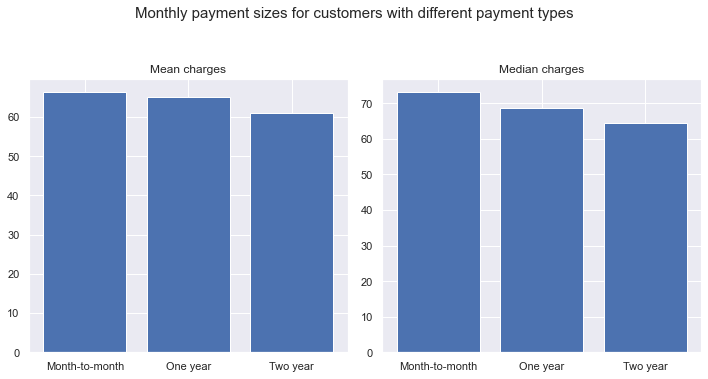

In [51]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].bar(x=df['Type'].unique(), height=df.groupby('Type')['MonthlyCharges'].mean())
axs[1].bar(x=df['Type'].unique(), height=df.groupby('Type')['MonthlyCharges'].median())

axs[0].title.set_text('Mean charges')
axs[1].title.set_text('Median charges')

plt.suptitle('Monthly payment sizes for customers with different payment types', fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

You can be see that the longer the period for which customers immediately pay, the cheaper it is every month. 

However this difference does not explain the spike near 20$ on monthly charges distribution chart.

I will analyze all three payment types separately to get a better understanding of this distribution.

In [52]:
df['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

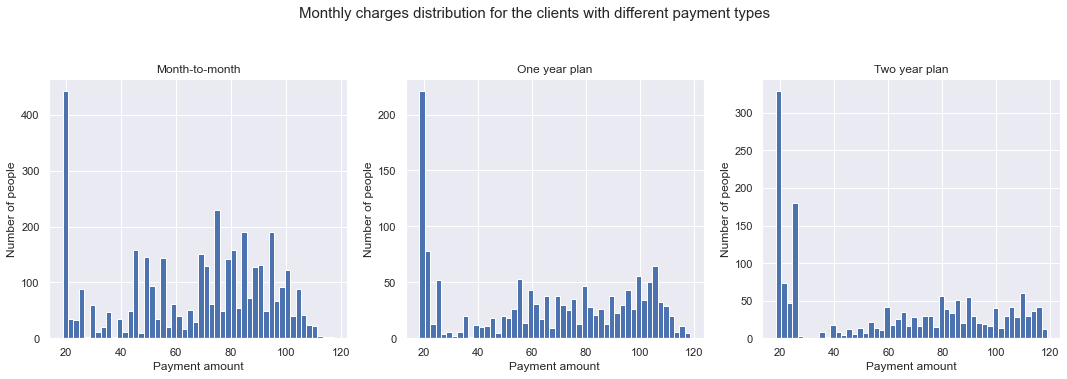

In [53]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
axs[0].hist(df.loc[df['Type'] == 'Month-to-month']['MonthlyCharges'], bins=50)
axs[0].set_xlabel('Payment amount')
axs[0].set_ylabel('Number of people')
axs[0].title.set_text('Month-to-month')

axs[1].hist(df.loc[df['Type'] == 'One year']['MonthlyCharges'], bins=50)
axs[1].set_xlabel('Payment amount')
axs[1].set_ylabel('Number of people')
axs[1].title.set_text('One year plan')

axs[2].hist(df.loc[df['Type'] == 'Two year']['MonthlyCharges'], bins=50)
axs[2].set_xlabel('Payment amount')
axs[2].set_ylabel('Number of people')
axs[2].title.set_text('Two year plan')

plt.suptitle('Monthly charges distribution for the clients with different payment types', fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

Clients with all three types of payment use different tariffs and cheaper tariffs with a monthly payment of ~20$ are the most popular everywhere.

You can also see from the charts that month-to-month customers are more likely to select more expensive rates which explains the higher average monthly check from these customers.

Let's check the numeric features influence on the target variable

In [54]:
nonbinary_features = ['Type', 'PaymentMethod', 'InternetService']
binary_features = cat_features.copy()

for i in nonbinary_features:
    binary_features.remove(i)
binary_features.remove('Left')

In [55]:
def binary_hypothesis_test(df, binary_features, target, alpha=0.05):
    effect_features = []
    no_effect_features = []

    print('Null hypothesis — feature has no effect on the selected variable')
    print('Alternative hypothesis — feature has effect on the selected variable')
    print()

    for feature in binary_features:

        group_1 = df[df[feature]==df[feature].unique()[0]][target]
        group_2 = df[df[feature]==df[feature].unique()[1]][target]

        results = st.ttest_ind(group_1, group_2)

        print("Признак", feature)
        print('p-value =', results.pvalue)

        if results.pvalue < alpha:
            effect_features.append(feature)
            print("Reject the null hypothesis")
        else:
            no_effect_features.append(feature)
            print("Can't reject the null hypothesis")
        print()
        
    return effect_features, no_effect_features

In [56]:
def nonbinary_hypothesis_test(df, nonbinary_features, target, alpha=0.05):
    # a binary_hypothesis_test for multiple comparisons
    # uses Bonferroni correction for multiple comparisons
    effect_features = []
    no_effect_features = []
    
    for feature in nonbinary_features:
        print('Categories', feature)
        categories_count = len(df[feature].unique())
        # apply the Bonferroni correction
        alpha = 0.05 / (categories_count * (categories_count - 1) / 2)
        print('alpha =', alpha)
        print()
        
        cat_1 = df[feature].unique()[0]
        cat_2 = df[feature].unique()[1]
        cat_3 = df[feature].unique()[2]

        for i in [[cat_1, cat_2], [cat_2, cat_3], [cat_1, cat_3]]:
            results = st.ttest_ind(df[df[feature]==i[0]][target], 
                                   df[df[feature]==i[1]][target])
            print('Categories', i[0], 'and', i[1])
            print('p-value =', results.pvalue)

            if results.pvalue < alpha:
                effect_features.append(feature)
                print("Reject the null hypothesis")
            else:
                no_effect_features.append(feature)
                print("Can't reject the null hypothesis")
            print()
        
        if categories_count == 4:
            cat_4 = df[feature].unique()[3]

            for i in [[cat_1, cat_4], [cat_2, cat_4], [cat_3, cat_4]]:
                results = st.ttest_ind(df[df[feature]==i[0]][target],
                                       df[df[feature]==i[1]][target])
                
                print('Categories', i[0], 'and', i[1])
                print('p-value =', results.pvalue)

                if results.pvalue < alpha:
                    effect_features.append(feature)
                    print("Reject the null hypothesis")
                else:
                    no_effect_features.append(feature)
                    print("Can't reject the null hypothesis")
                print()

In [57]:
binary_hypothesis_test(df, binary_features, 'MonthlyCharges');

Null hypothesis — feature has no effect on the selected variable
Alternative hypothesis — feature has effect on the selected variable

Признак gender
p-value = 0.24795008894392226
Can't reject the null hypothesis

Признак SeniorCitizen
p-value = 9.798165838182686e-78
Reject the null hypothesis

Признак Partner
p-value = 2.008438449548186e-16
Reject the null hypothesis

Признак Dependents
p-value = 3.420983730311507e-21
Reject the null hypothesis

Признак PaperlessBilling
p-value = 3.855832008458749e-204
Reject the null hypothesis

Признак OnlineSecurity
p-value = 1.2224404300331057e-142
Reject the null hypothesis

Признак OnlineBackup
p-value = 0.0
Reject the null hypothesis

Признак DeviceProtection
p-value = 0.0
Reject the null hypothesis

Признак TechSupport
p-value = 8.061335844458226e-188
Reject the null hypothesis

Признак StreamingTV
p-value = 0.0
Reject the null hypothesis

Признак StreamingMovies
p-value = 0.0
Reject the null hypothesis

Признак MultipleLines
p-value = 0.0
Rej

In [58]:
nonbinary_hypothesis_test(df, ['Type', 'InternetService'], 'MonthlyCharges')

Categories Type
alpha = 0.016666666666666666

Categories Month-to-month and One year
p-value = 0.1287939235271868
Can't reject the null hypothesis

Categories One year and Two year
p-value = 0.0004204174613470584
Reject the null hypothesis

Categories Month-to-month and Two year
p-value = 1.4882072080055037e-10
Reject the null hypothesis

Categories InternetService
alpha = 0.016666666666666666

Categories DSL and Fiber optic
p-value = 0.0
Reject the null hypothesis

Categories Fiber optic and No
p-value = 0.0
Reject the null hypothesis

Categories DSL and No
p-value = 0.0
Reject the null hypothesis



In [59]:
nonbinary_hypothesis_test(df, ['PaymentMethod'], 'MonthlyCharges')

Categories PaymentMethod
alpha = 0.008333333333333333

Categories Electronic check and Mailed check
p-value = 1.2670043808438404e-293
Reject the null hypothesis

Categories Mailed check and Bank transfer (automatic)
p-value = 2.4376548113739466e-107
Reject the null hypothesis

Categories Electronic check and Bank transfer (automatic)
p-value = 1.2964353299732858e-24
Reject the null hypothesis

Categories Electronic check and Credit card (automatic)
p-value = 5.898116407778843e-28
Reject the null hypothesis

Categories Mailed check and Credit card (automatic)
p-value = 7.222559113579074e-101
Reject the null hypothesis

Categories Bank transfer (automatic) and Credit card (automatic)
p-value = 0.5348440013291733
Can't reject the null hypothesis



It looks like people that use internet services tend to pay more.

I will extract the Internet usage as a binary feature for the model building.

In [60]:
names = ['DSL', 'Fiber optic', 'No']
new_names = ['Yes', 'Yes', 'No']
df['Internet'] = df['InternetService'].replace(names, new_names)

In [61]:
df['Internet'].value_counts()

Yes    5512
No     1520
Name: Internet, dtype: int64

In [62]:
cat_features.append('Internet')

### TotalCharges

In [63]:
df['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

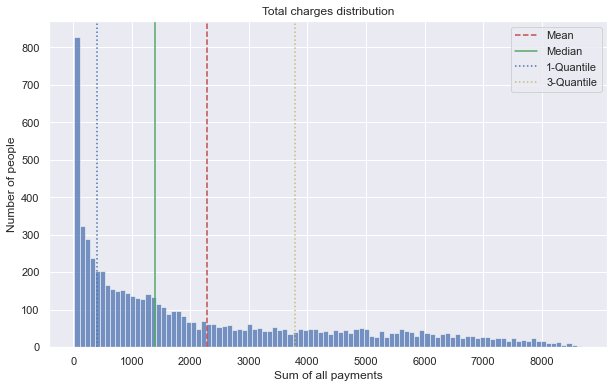

In [64]:
mean = df['TotalCharges'].mean()
median = df['TotalCharges'].median()
Q1 = df['TotalCharges'].quantile(q=0.25)
Q3 = df['TotalCharges'].quantile(q=0.75)


fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data=df['TotalCharges'], bins=100)
ax.axvline(mean, color='r', linestyle='--', label="Mean")
ax.axvline(median, color='g', linestyle='-', label="Median")
ax.axvline(Q1, color='b', linestyle=':', label="1-Quantile")
ax.axvline(Q3, color='y', linestyle=':', label="3-Quantile")

ax.legend()
ax.xaxis.set_ticks(np.arange(0, 9000, 1000))
plt.title('Total charges distribution')
ax.set_xlabel('Sum of all payments')
ax.set_ylabel('Number of people')
plt.show()

You can see the Poisson distribution with a shift to the right side - the mean is almost twice higher than the median.\
It indicates that the maximum values pull the mean towards itself to the right. This is also evidenced by the fact that the maximum value is more than twice bigger than the 3-rd quartile.

We can also obseve a spike near 100$ mark — more than 800 clients of clients paid only ~ 100 USD during their lifetime. These can be either the clients that just started using the telecom services or the clients who left the operator after a month or two after they started using the service.

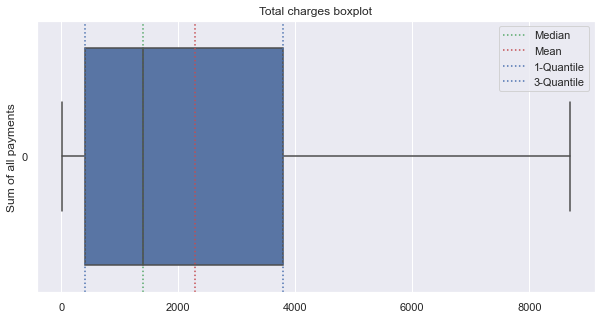

In [65]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.boxplot(data = df['TotalCharges'], orient='h')
ax.axvline(median, color='g', linestyle=':', label="Median")
ax.axvline(mean, color='r', linestyle=':', label="Mean")
ax.axvline(Q1, color='b', linestyle=':', label="1-Quantile")
ax.axvline(Q3, color='b', linestyle=':', label="3-Quantile")

ax.legend()
ax.set_title('Total charges boxplot')
ax.set_ylabel('Sum of all payments')
plt.show()

The boxplot also indicates that the data is elongated to the right side.\
However the payments don't go beyond 1.5 interquartile ranges.\
This can indicate that even the highest payments should not be considered as outliers or anomalies.

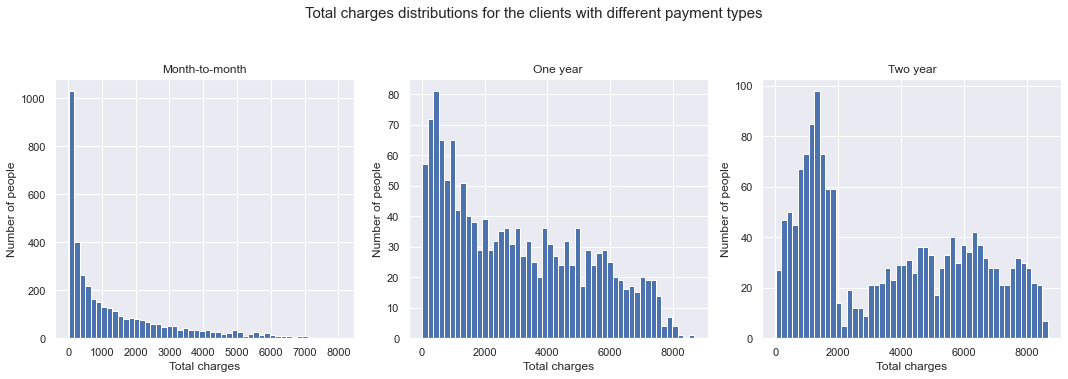

In [66]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
axs[0].hist(df.loc[df['Type'] == 'Month-to-month']['TotalCharges'], bins=50)
axs[0].set_xlabel('Total charges')
axs[0].set_ylabel('Number of people')
axs[0].title.set_text('Month-to-month')

axs[1].hist(df.loc[df['Type'] == 'One year']['TotalCharges'], bins=50)
axs[1].set_xlabel('Total charges')
axs[1].set_ylabel('Number of people')
axs[1].title.set_text('One year')

axs[2].hist(df.loc[df['Type'] == 'Two year']['TotalCharges'], bins=50)
axs[2].set_xlabel('Total charges')
axs[2].set_ylabel('Number of people')
axs[2].title.set_text('Two year')

plt.suptitle('Total charges distributions for the clients with different payment types', fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

Customers with different payment types bring in different amounts of money during their lifetime.\
There is nothing unexpected about it - if customers immediately pay for a year or two, then their LTV will on average be higher than that of customers paying for the operator's services monthly.

## Time trends analysis

In [67]:
df['BeginDate'].describe()

count                    7032
unique                     76
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-01-01 00:00:00
Name: BeginDate, dtype: object

In [68]:
new_clients_date = df.groupby('BeginDate')['customerID'].count()

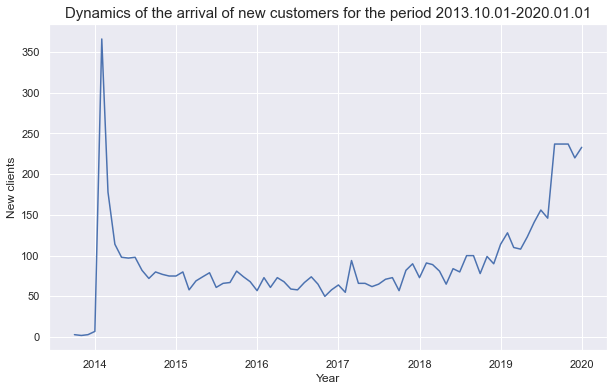

In [69]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=new_clients_date)

plt.title('Dynamics of the arrival of new customers for the period 2013.10.01-2020.01.01', fontsize=15)
plt.xlabel("Year")
plt.ylabel("New clients")
plt.show()

Most of the clients came at the beginning of 2014. Until 2018 50-100 people came every month.

Starting 2018 and until the beginning of 2020 the number of monthly new clients began to grow. 

In [70]:
left_clients_date = df.groupby('EndDate')['customerID'].count()

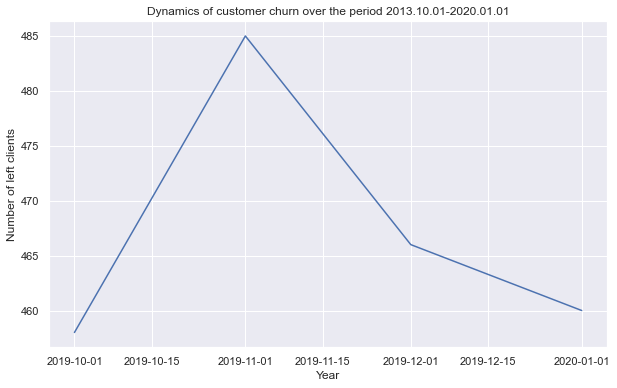

In [71]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=left_clients_date)

plt.title('Dynamics of customer churn over the period 2013.10.01-2020.01.01')
plt.xlabel("Year")
plt.ylabel("Number of left clients")
plt.show()

A somewhat strange chart. Apparently, according to the available data customers left only at the end of 2019 - the beginning of 2020 and on specific 4 dates.

In [72]:
left_clients_date

EndDate
2019-10-01    458
2019-11-01    485
2019-12-01    466
2020-01-01    460
Name: customerID, dtype: int64

It turns out that all clients in the dataset left on 4 specific dates near the end of 2019 and at the beginning of 2020 and in similar sized batches.

I can suggest that this is some kind of large corporate client ending its cooperation with the operator. In this case we can't really build a classifier for future clients using this data.\
To check this hypothesis I can study the behaviour of these clients and time when they joined the operator.\
If these clients appear to have similar packages and were registered on the same date, I can conclude that the classifier can not be build based on this data.

Otherwise, I can suggest that some event could have caused people to leave the telecom provider in batches. It could be an aggressive marketing campaign by a new competitor or a similar event.

In [73]:
left_clients = df.loc[df['Left']==1]

In [74]:
left_clients.describe()

SeniorCitizen  MonthlyCharges  TotalCharges    Left
count    1869.000000     1869.000000   1869.000000  1869.0
mean        0.254682       74.441332   1531.796094     1.0
std         0.435799       24.666053   1890.822994     0.0
min         0.000000       18.850000     18.850000     1.0
25%         0.000000       56.150000    134.500000     1.0
50%         0.000000       79.650000    703.550000     1.0
75%         1.000000       94.200000   2331.300000     1.0
max         1.000000      118.350000   8684.800000     1.0

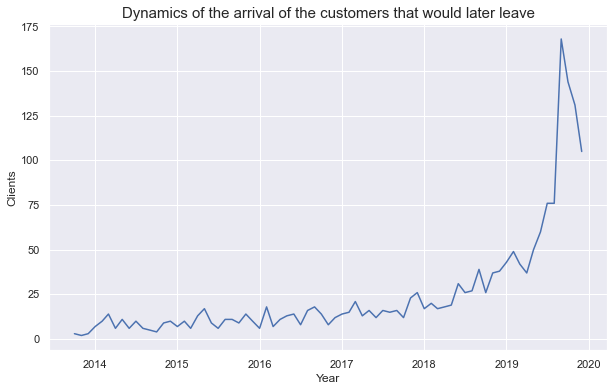

In [75]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=left_clients.groupby('BeginDate')['customerID'].count())

plt.title('Dynamics of the arrival of the customers that would later leave', fontsize=15)
plt.xlabel("Year")
plt.ylabel("Clients")
plt.show()

Most of the new users who came in 2019 left.

This suggests the idea of creating a "User Lifetime" feature, based on which the model could give a greater "threat" of leaving to the new users.

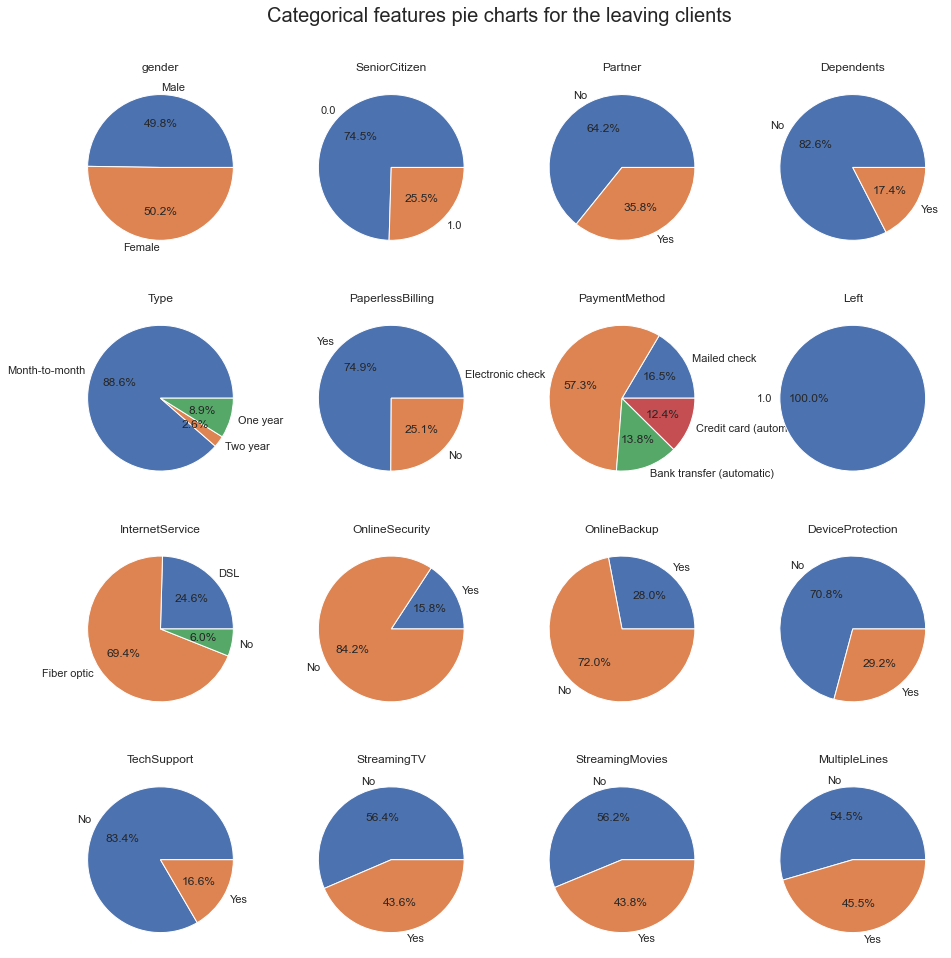

In [76]:
fig, axs = plt.subplots(4,4, figsize = (13,13))
plt.tight_layout()
count = -1
for i in range(4):
    for x in range(4):
        count+=1
        col = cat_features[count]
        axs[i,x].pie(x=label_size(left_clients, col)[1],
                     labels=label_size(left_clients, col)[0], 
                     autopct='%1.1f%%',)
        axs[i,x].title.set_text(str(col))

plt.suptitle('Categorical features pie charts for the leaving clients', fontsize=20, y=1.05)
plt.show()

You can spot an interesting detail — almost all of the departed customers used to pay on a monthly basis.

It can be expected that the model will give this feature a large weight.

Let's extract the user lifetime as a feature and see if it's useful or not.

In [77]:
last_date = df['EndDate'].copy().fillna(value = pd.to_datetime('2020-02-01'))

In [78]:
last_date.describe()

count                    7032
unique                      5
top       2020-02-01 00:00:00
freq                     5163
first     2019-10-01 00:00:00
last      2020-02-01 00:00:00
Name: EndDate, dtype: object

In [79]:
df['lifetime'] = last_date - df['BeginDate']

In [80]:
df['lifetime'] = df['lifetime'].dt.days.astype('int16')

In [81]:
df['lifetime']

0         31
1       1036
2         61
3       1371
4         61
        ... 
7027     730
7028    2191
7029     337
7030     123
7031    2010
Name: lifetime, Length: 7032, dtype: int16

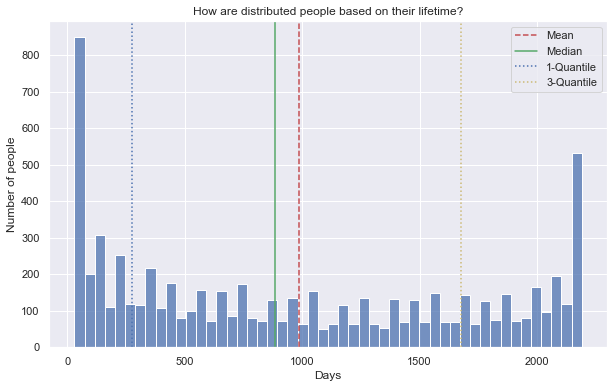

In [82]:
mean = df['lifetime'].mean()
median = df['lifetime'].median()
Q1 = df['lifetime'].quantile(q=0.25)
Q3 = df['lifetime'].quantile(q=0.75)


fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data=df['lifetime'], bins=50)
ax.axvline(mean, color='r', linestyle='--', label="Mean")
ax.axvline(median, color='g', linestyle='-', label="Median")
ax.axvline(Q1, color='b', linestyle=':', label="1-Quantile")
ax.axvline(Q3, color='y', linestyle=':', label="3-Quantile")

ax.legend()
plt.title('How are distributed people based on their lifetime?')
ax.set_xlabel('Days')
ax.set_ylabel('Number of people')
plt.show()

In [83]:
df['lifetime'].describe()

count    7032.000000
mean      987.538538
std       747.153663
min        30.000000
25%       275.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: lifetime, dtype: float64

В целом клиенты равномерно распределены по графику, что соотносится с наблюдением того, как клиенты приходили к оператору.

Выделяются спайки в начале и в конце графика — туда входят клиенты, которые просто недавно пришли к оператору, так и те, кто пришел и в тот же год ушел от оператора (таких также было довольно много)

Спайк в конце графика объясняется старыми клиентами, зашедшими в 2014 году, когда оператор активнее всгео привлекал клиентов.

In general, clients are evenly distributed over the schedule, which correlates with the observation of how clients came to the operator.

The distribution is bimodal and has the spikes are located near the left and right borders of the chart. 

The spike at the end of the chart can be explained by old customers who entered in 2014 when the operator was more active attracting new customers.

Let's take a look at the monthly payments of the customers. This information will be usefull for train/test/validation split later on.

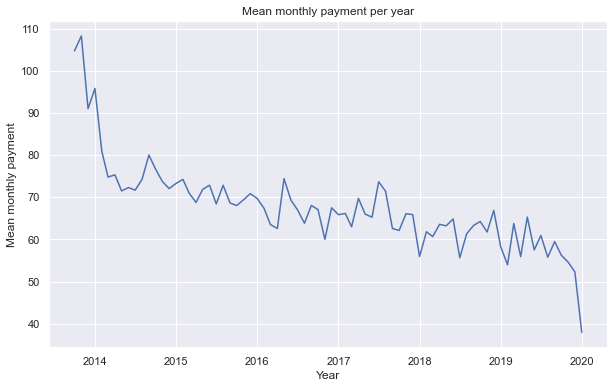

In [84]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df.groupby('BeginDate')['MonthlyCharges'].mean())

plt.title('Mean monthly payment per year')
plt.xlabel("Year")
plt.ylabel("Mean monthly payment")
plt.show()

The chart shows that customers who came earlier pay the most per month on average.

After 2015, the monthly payment slowly decreases from 70$ to 60$ by 2018.

## Correlations

In [85]:
df.describe()

SeniorCitizen  MonthlyCharges  TotalCharges         Left     lifetime
count    7032.000000     7032.000000   7032.000000  7032.000000  7032.000000
mean        0.162400       64.798208   2283.300441     0.265785   987.538538
std         0.368844       30.085974   2266.771362     0.441782   747.153663
min         0.000000       18.250000     18.800000     0.000000    30.000000
25%         0.000000       35.587500    401.450000     0.000000   275.000000
50%         0.000000       70.350000   1397.475000     0.000000   883.000000
75%         0.000000       89.862500   3794.737500     1.000000  1676.000000
max         1.000000      118.750000   8684.800000     1.000000  2191.000000

In [86]:
df[['MonthlyCharges', 'TotalCharges', 'lifetime']].corr()

MonthlyCharges  TotalCharges  lifetime
MonthlyCharges        1.000000      0.651065  0.246715
TotalCharges          0.651065      1.000000  0.825811
lifetime              0.246715      0.825811  1.000000

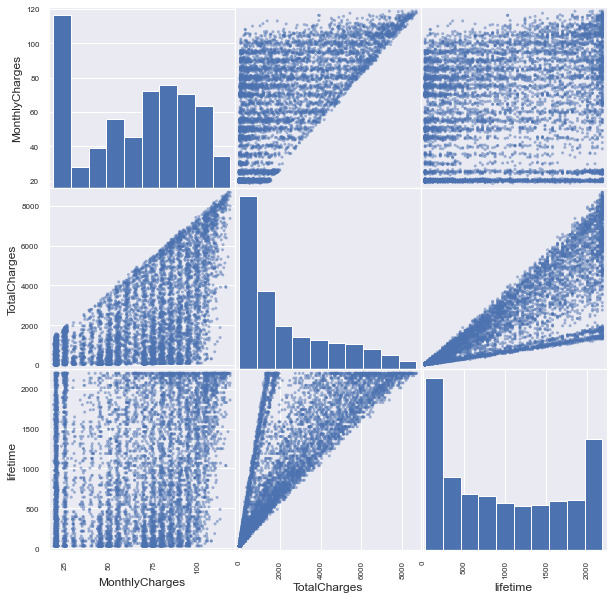

In [87]:
pd.plotting.scatter_matrix(df[['MonthlyCharges', 'TotalCharges', 'lifetime']], figsize = [10,10])
plt.show()

TotalCharges and Lifetime features are highly correlated which is quite obvious — the longer the client stays with the operator, the more they pay.

For now, I'll leave both features. If necessary, I will check the models performace with only one of those features.

Let's also check the correlations among different churn groups.

We've got 4 of these, one for a specific date when the client has left.

In [88]:
left_clients_date

EndDate
2019-10-01    458
2019-11-01    485
2019-12-01    466
2020-01-01    460
Name: customerID, dtype: int64


EndDate = 2019-10-01 00:00:00
                MonthlyCharges  TotalCharges  lifetime
MonthlyCharges        1.000000      0.542969  0.394498
TotalCharges          0.542969      1.000000  0.955990
lifetime              0.394498      0.955990  1.000000



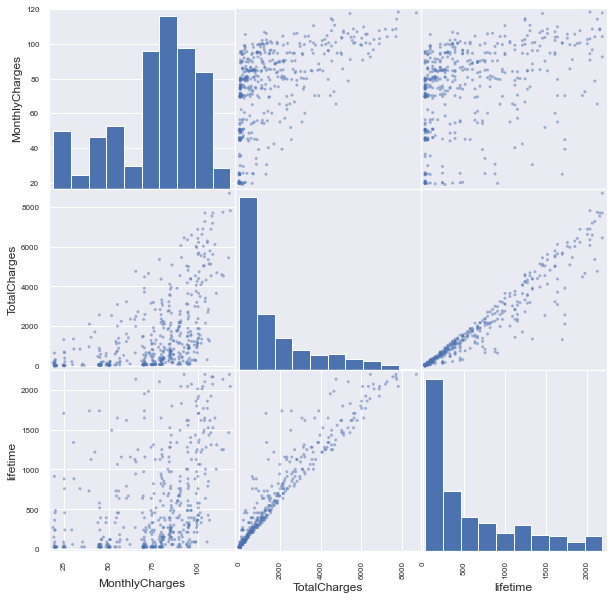



EndDate = 2019-11-01 00:00:00
                MonthlyCharges  TotalCharges  lifetime
MonthlyCharges        1.000000      0.497763  0.322997
TotalCharges          0.497763      1.000000  0.947264
lifetime              0.322997      0.947264  1.000000



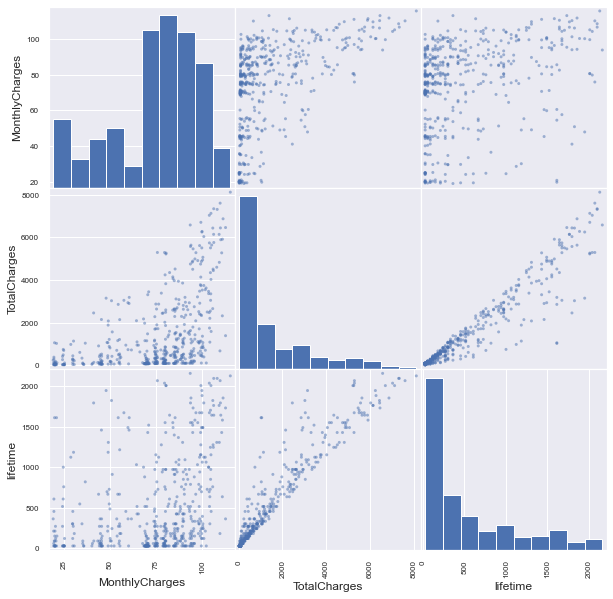



EndDate = 2019-12-01 00:00:00
                MonthlyCharges  TotalCharges  lifetime
MonthlyCharges        1.000000      0.581961  0.474368
TotalCharges          0.581961      1.000000  0.963483
lifetime              0.474368      0.963483  1.000000



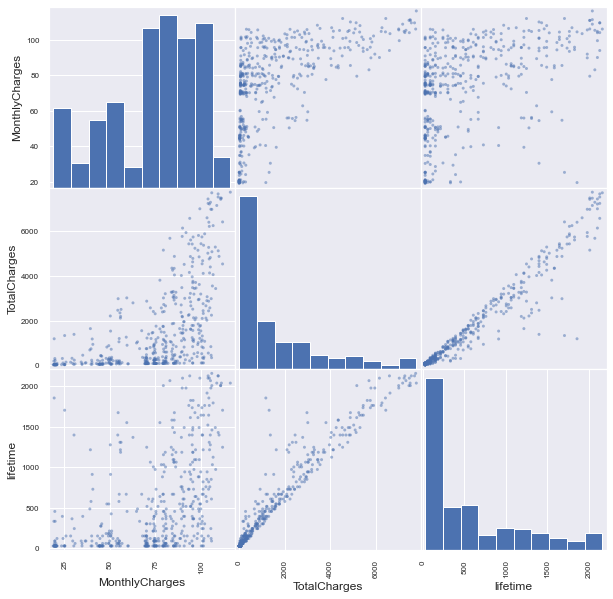



EndDate = 2020-01-01 00:00:00
                MonthlyCharges  TotalCharges  lifetime
MonthlyCharges        1.000000      0.558870  0.409776
TotalCharges          0.558870      1.000000  0.949074
lifetime              0.409776      0.949074  1.000000



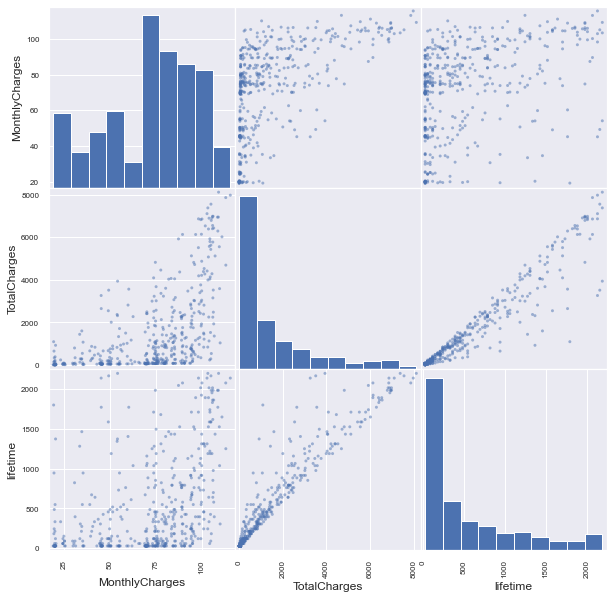

In [89]:
quant_features = ['MonthlyCharges', 'TotalCharges', 'lifetime']

for date in left_clients_date.index:
    print()
    print('EndDate =', date)
    print(df.loc[df['EndDate']==date][quant_features].corr())
    print()
    pd.plotting.scatter_matrix(df.loc[df['EndDate']==date][quant_features], figsize = [10,10])
    plt.show()
    print()

It becomes clear that the TotalCharges and lifetime features are almost completely correlated (Correlation coefficient > 0.95) if we study each group separetely.

In this situation I will remove one of these features.

UPD: after comparing models with TotalCharges or lifetime features, the models kept giving the lifetime feature higher feature importance score. This is why I exclude TotalCharges

In [90]:
df.drop('TotalCharges', axis=1, inplace=True)

# Prepare the data

Before training I will delete data that is definitely unnecessary for training models (customer ids, EndDate which is virtually a target).\
Also taking into account the fact that I have the lifetime feature I can remove the BeginDate.

In [91]:
df.drop('EndDate', axis=1, inplace=True)
df.drop('customerID', axis=1, inplace=True)
df.drop('BeginDate', axis=1, inplace=True)

In [92]:
df.head()

gender  SeniorCitizen Partner Dependents            Type PaperlessBilling  \
0  Female            0.0     Yes         No  Month-to-month              Yes   
1    Male            0.0      No         No        One year               No   
2    Male            0.0      No         No  Month-to-month              Yes   
3    Male            0.0      No         No        One year               No   
4  Female            0.0      No         No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  Left InternetService  \
0           Electronic check           29.85   0.0             DSL   
1               Mailed check           56.95   0.0             DSL   
2               Mailed check           53.85   1.0             DSL   
3  Bank transfer (automatic)           42.30   0.0             DSL   
4           Electronic check           70.70   1.0     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies MultipleLines Internet  lifetime  
0              No            No      Yes        31  
1              No            No      Yes      1036  
2              No            No      Yes        61  
3              No            No      Yes      1371  
4              No            No      Yes        61

## OHE the categorical features

In [93]:
cat_features.remove('Left')

In [94]:
cat_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Internet']

In [95]:
data_ohe = pd.get_dummies(df[cat_features], drop_first=True)

In [96]:
data_ohe.head()

SeniorCitizen  gender_Male  Partner_Yes  Dependents_Yes  Type_One year  \
0            0.0            0            1               0              0   
1            0.0            1            0               0              1   
2            0.0            1            0               0              0   
3            0.0            1            0               0              1   
4            0.0            0            0               0              0   

   Type_Two year  PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0              0                     1                                      0   
1              0                     0                                      0   
2              0                     1                                      0   
3              0                     0                                      0   
4              0                     1                                      0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
0                               1                           0   
1                               0                           1   
2                               0                           1   
3                               0                           0   
4                               1                           0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
0                            0                   0                   0   
1                            0                   0                   1   
2                            0                   0                   1   
3                            0                   0                   1   
4                            1                   0                   0   

   OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0                 1                     0                0                0   
1                 0                     1                0                0   
2                 1                     0                0                0   
3                 0                     1                1                0   
4                 0                     0                0                0   

   StreamingMovies_Yes  MultipleLines_Yes  Internet_Yes  
0                    0                  0             1  
1                    0                  0             1  
2                    0                  0             1  
3                    0                  0             1  
4                    0                  0             1

In [97]:
df_encoded = df.drop(cat_features, axis=1)

In [98]:
df_encoded = df_encoded.join(data_ohe)

In [99]:
# convert all column names to str
df_encoded.columns = [str(i) for i in list(df_encoded.columns)]

In [100]:
df_encoded.head()

MonthlyCharges  Left  lifetime  SeniorCitizen  gender_Male  Partner_Yes  \
0           29.85   0.0        31            0.0            0            1   
1           56.95   0.0      1036            0.0            1            0   
2           53.85   1.0        61            0.0            1            0   
3           42.30   0.0      1371            0.0            1            0   
4           70.70   1.0        61            0.0            0            0   

   Dependents_Yes  Type_One year  Type_Two year  PaperlessBilling_Yes  \
0               0              0              0                     1   
1               0              1              0                     0   
2               0              0              0                     1   
3               0              1              0                     0   
4               0              0              0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  InternetService_Fiber optic  \
0                           0                            0   
1                           1                            0   
2                           1                            0   
3                           0                            0   
4                           0                            1   

   InternetService_No  OnlineSecurity_Yes  OnlineBackup_Yes  \
0                   0                   0                 1   
1                   0                   1                 0   
2                   0                   1                 1   
3                   0                   1                 0   
4                   0                   0                 0   

   DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0                     0                0                0   
1                     1                0                0   
2                     0                0                0   
3                     1                1                0   
4                     0                0                0   

   StreamingMovies_Yes  MultipleLines_Yes  Internet_Yes  
0                    0                  0             1  
1                    0                  0             1  
2                    0                  0             1  
3                    0                  0             1  
4                    0                  0             1

Encoding done, the data is ready

## Train test split

In [101]:
random_state = 12345

In [102]:
# 20% test sample, make sure to stratify it
train, test = train_test_split(df_encoded, test_size=0.2, stratify=df_encoded['Left'])

In [103]:
y_train = train['Left']
X_train = train.drop('Left', axis=1)

y_test = test['Left']
X_test = test.drop('Left', axis=1)

In [104]:
print(y_train.shape)
print(X_train.shape)

print(X_test.shape)
print(y_test.shape)

(5625,)
(5625, 22)
(1407, 22)
(1407,)


## Scaling the features

In [105]:
for x in [X_train, X_test]:
    scaler = StandardScaler()
    scaler.fit(x[['MonthlyCharges', 'lifetime']])
    x[['MonthlyCharges', 'lifetime']] = scaler.transform(x[['MonthlyCharges', 'lifetime']])

In [106]:
X_train.head()

MonthlyCharges  lifetime  SeniorCitizen  gender_Male  Partner_Yes  \
1373        0.064263  1.034878            0.0            0            1   
5952       -0.961385 -1.288061            0.0            0            0   
3571        0.017793  0.135676            0.0            1            0   
3217       -0.662653 -1.246580            0.0            1            0   
5585        0.626876 -0.390197            0.0            0            1   

      Dependents_Yes  Type_One year  Type_Two year  PaperlessBilling_Yes  \
1373               1              0              0                     1   
5952               0              0              0                     0   
3571               0              1              0                     1   
3217               0              0              0                     0   
5585               1              0              0                     1   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1373                                      0                               0   
5952                                      0                               0   
3571                                      0                               0   
3217                                      0                               0   
5585                                      0                               1   

      PaymentMethod_Mailed check  InternetService_Fiber optic  \
1373                           0                            0   
5952                           1                            0   
3571                           1                            0   
3217                           0                            0   
5585                           0                            1   

      InternetService_No  OnlineSecurity_Yes  OnlineBackup_Yes  \
1373                   0                   0                 1   
5952                   0                   0                 0   
3571                   0                   0                 1   
3217                   0                   0                 0   
5585                   0                   0                 0   

      DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
1373                     0                0                1   
5952                     1                1                0   
3571                     0                1                0   
3217                     0                0                0   
5585                     0                0                1   

      StreamingMovies_Yes  MultipleLines_Yes  Internet_Yes  
1373                    0                  1             1  
5952                    0                  0             1  
3571                    1                  0             1  
3217                    0                  0             1  
5585                    0                  1             1

Scaling done

# Model building

I'll use ROC AUC metric to measure the quality of the models and compare them

In [107]:
def ROC_curve_builder(target, probabilities):
    
    fpr, tpr, thresholds = roc_curve(target, probabilities)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()

In [108]:
def get_test_roc_auc(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    probs_one = probs[:, 1]
    roc_auc = round(roc_auc_score(y_test, probs_one), 4)
    return roc_auc

In [109]:
# table to collect model performance results
table = pd.DataFrame(columns = ['Model', 'ROC_AUC'])

In [110]:
def add_to_table(model_name, roc_auc, table=table):
    table = table.append({'Model':model_name,
                          'ROC_AUC':roc_auc}, 
                         ignore_index=True)
    return table

## Logistic regression

In [111]:
model = LogisticRegression(random_state=random_state)

cv_results = cross_validate(model, X_train, y_train, scoring='roc_auc', cv=5)
mean_cv_result = round(cv_results['test_score'].mean(), 4)

print('4 samples cross validation mean ROC AUC', mean_cv_result)

4 samples cross validation mean ROC AUC 0.8427


In [112]:
clf = LogisticRegression(random_state=random_state).fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('Test set ROC AUC', round(roc_auc, 4))

Test set ROC AUC 0.8432


In [113]:
LR_model = clf

In [114]:
table = add_to_table('LogisticRegression', round(roc_auc, 4), table)

## Random Forest

In [115]:
model = RandomForestClassifier(random_state=random_state)

params = {'n_estimators': range(1, 1001, 100),
          'max_depth': range(1,8, 1)}

In [116]:
grid = GridSearchCV(estimator=model,
                    cv=3,
                    param_grid=params,
                    verbose=1,
                    scoring='roc_auc')

#grid.fit(X_train, y_train)
#best_params = grid.best_params_
#print(best_params)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
{'max_depth': 7, 'n_estimators': 501}


In [117]:
# save best params
best_params = {'max_depth': 7, 'n_estimators': 601}

In [118]:
best_model = RandomForestClassifier(max_depth=best_params['max_depth'],
                                    n_estimators=best_params['n_estimators'],
                                    random_state=random_state)

clf = best_model.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('ROC AUC на тестовом сете', round(roc_auc, 4))

ROC AUC на тестовом сете 0.846


In [119]:
RF_model = clf

In [120]:
table = add_to_table('RandomForest', round(roc_auc, 4), table)

## CatBoostClassifier

### CatBoostClassifier no parameter tuning

In [121]:
model = CatBoostClassifier(random_seed=random_state, verbose=0)

clf = model.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print('Test set ROC AUC', round(roc_auc, 4))

Test set ROC AUC 0.8195


### CatBoostClassifier finding best params with gridsearchcv

In [122]:
model = CatBoostClassifier()

params = {'depth':[2, 3, 4, 5, 6],
          'iterations': [100, 250, 500],
          'learning_rate':[0.01, 0.005, 0.001],
          'l2_leaf_reg':[1, 2, 3, 10],
           #'use_best_model': ['True'],
          'random_seed': [random_state],
          #'thread_count': [-1],
          'logging_level':['Silent']
         }

In [123]:
grid = GridSearchCV(estimator=model,
                    cv=3,
                    param_grid=params,
                    verbose=1,
                    scoring='roc_auc')

#grid.fit(X_train, y_train)
#best_params = grid.best_params_
#print(best_params)

In [124]:
# save best params
best_params = {'depth': 4, 
               'iterations': 500, 
               'l2_leaf_reg': 1, 
               'learning_rate': 0.01, 
               'logging_level': 'Silent', 
               'random_seed': 12345}

In [125]:
best_model = CatBoostClassifier(depth=best_params['depth'],
                          iterations=best_params['iterations'],
                          l2_leaf_reg=best_params['l2_leaf_reg'],
                          learning_rate=best_params['learning_rate'],    
                          logging_level='Silent',
                          random_seed=random_state,
                          #thread_count=-1
                               )

clf = best_model.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print('Test set ROC AUC', round(roc_auc, 4))

Test set ROC AUC 0.8396


In [126]:
CBC_model = clf

In [127]:
table = add_to_table('CatBoost', round(roc_auc, 4), table)

In [128]:
feature_importances = pd.DataFrame({'feature':list(X_train.columns),
                                    'importance':best_model.feature_importances_})

feature_importances =\
feature_importances.sort_values('importance',ascending = False).reset_index(drop=True)

In [129]:
feature_importances

feature  importance
0                                lifetime   57.301394
1                           Type_Two year   10.841954
2             InternetService_Fiber optic    7.780339
3                          MonthlyCharges    4.338999
4                           Type_One year    4.076335
5                            Internet_Yes    2.580680
6          PaymentMethod_Electronic check    2.144903
7                      InternetService_No    1.771629
8                     StreamingMovies_Yes    1.546379
9                         TechSupport_Yes    1.416417
10                   PaperlessBilling_Yes    1.295158
11                     OnlineSecurity_Yes    1.203492
12                      MultipleLines_Yes    1.139681
13                        StreamingTV_Yes    0.916593
14                          SeniorCitizen    0.828029
15  PaymentMethod_Credit card (automatic)    0.247903
16             PaymentMethod_Mailed check    0.208426
17                            gender_Male    0.122278
18                         Dependents_Yes    0.099024
19                   DeviceProtection_Yes    0.064159
20                       OnlineBackup_Yes    0.047694
21                            Partner_Yes    0.028534

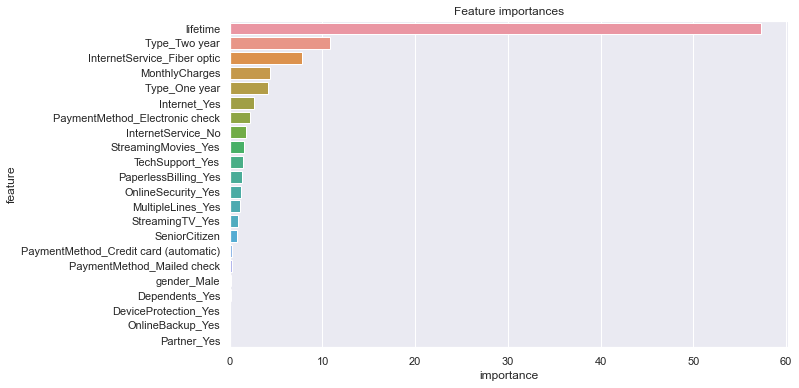

In [130]:
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(y='feature', x='importance', data=feature_importances, orient='h')
plt.title('Feature importances')
plt.show()

###  CatBoostClassifier with params that have feature_importances > 1%

In [131]:
useful_features = list(feature_importances[feature_importances['importance'] > 1]['feature'])
useful_features

['lifetime',
 'Type_Two year',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'Type_One year',
 'Internet_Yes',
 'PaymentMethod_Electronic check',
 'InternetService_No',
 'StreamingMovies_Yes',
 'TechSupport_Yes',
 'PaperlessBilling_Yes',
 'OnlineSecurity_Yes',
 'MultipleLines_Yes']

In [132]:
X_train_cut = X_train[useful_features]
X_test_cut = X_test[useful_features]

In [133]:
model = CatBoostClassifier()

params = {'depth':[2,3,4,5,6],
          'iterations': [100, 500, 750],
          'learning_rate':[0.01, 0.005],
          'l2_leaf_reg':[1, 3, 10],
           #'use_best_model': ['True'],
          'random_seed': [random_state],
          #'thread_count': [-1],
          'logging_level':['Silent']
         }

In [134]:
grid = GridSearchCV(estimator=model,
                    cv=3,
                    param_grid=params,
                    verbose=1,
                    scoring='roc_auc')

#grid.fit(X_train_cut, y_train)
#best_params = grid.best_params_
#print(best_params)
best_params = {'depth': 5, 
               'iterations': 750, 
               'l2_leaf_reg': 1, 
               'learning_rate': 0.01, 
               'logging_level': 'Silent', 
               'random_seed': 12345}

In [135]:
best_model = CatBoostClassifier(depth=best_params['depth'],
                          iterations=best_params['iterations'],
                          l2_leaf_reg=best_params['l2_leaf_reg'],
                          learning_rate=best_params['learning_rate'],    
                          logging_level='Silent',
                          random_seed=random_state,
                          #thread_count=-1
                               )

clf = best_model.fit(X_train_cut, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_cut)[:, 1])
print('Test set ROC AUC', round(roc_auc, 4))

Test set ROC AUC 0.8355


In [136]:
table = add_to_table('CatBoost_Cut', round(roc_auc, 4), table)

In [137]:
best_model.fit(X_train_cut, y_train)
predicts = best_model.predict(X_test_cut)

accuracy_score(y_test, predicts)

0.7803837953091685

In [138]:
feature_importances = pd.DataFrame({'feature':list(X_train_cut.columns),
                                    'importance':best_model.feature_importances_})

feature_importances =\
feature_importances.sort_values('importance',ascending = False).reset_index(drop=True)
feature_importances

feature  importance
0                         lifetime   58.444759
1                   MonthlyCharges    8.135664
2                    Type_Two year    8.110855
3      InternetService_Fiber optic    5.025656
4                    Type_One year    4.155343
5   PaymentMethod_Electronic check    2.432405
6               OnlineSecurity_Yes    2.199830
7              StreamingMovies_Yes    2.175512
8             PaperlessBilling_Yes    2.125729
9                  TechSupport_Yes    2.121047
10               MultipleLines_Yes    2.069479
11              InternetService_No    1.626381
12                    Internet_Yes    1.377340

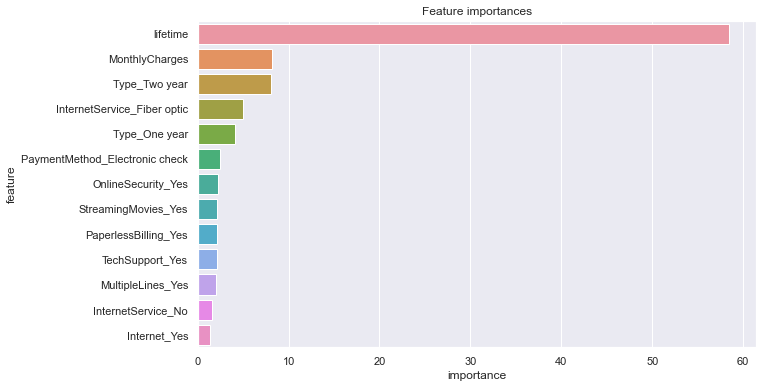

In [139]:
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(y='feature', x='importance', data=feature_importances, orient='h')
plt.title('Feature importances')
plt.show()

## Combine best models

In [140]:
# create a dictionary of the models
estimators=[('LR', LR_model), ('rf', RF_model), ('CBC', CBC_model)]
# create the voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

clf = ensemble.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print('Test set ROC AUC', round(roc_auc, 4))

Test set ROC AUC 0.8477


In [141]:
table = add_to_table('LR + RF + CatBoost', round(roc_auc, 4), table)

In [142]:
predicts = ensemble.predict(X_test)

In [143]:
precision = round(precision_score(y_test, predicts), 3)
print('Precision score =', precision)
print()
recall = round(recall_score(y_test, predicts), 3)
print('recall_score score =', recall)

Precision score = 0.673

recall_score score = 0.54


In [144]:
estimators=[('LR', LR_model), ('rf', RF_model)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

clf = ensemble.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print('Test set ROC AUC', round(roc_auc, 4))

Test set ROC AUC 0.847


In [145]:
table = add_to_table('LR + RF', round(roc_auc, 4), table)

In [146]:
predicts = ensemble.predict(X_test)

In [147]:
precision = round(precision_score(y_test, predicts), 3)
print('Precision score =', precision)
print()
recall = round(recall_score(y_test, predicts), 3)
print('recall_score score =', recall)

Precision score = 0.672

recall_score score = 0.521


# Conclusion

In [148]:
table.sort_values(by='ROC_AUC', ascending=False)

Model  ROC_AUC
4  LR + RF + CatBoost   0.8477
5             LR + RF   0.8470
1        RandomForest   0.8460
0  LogisticRegression   0.8432
2            CatBoost   0.8396
3        CatBoost_Cut   0.8355

All models gave an approximate result of 0.83 - 0.85 ROC AUC

When combining the best models into an ensemble, they give the same or slightly better result.

With the help of accuracy and recall metrics the business can select which models would be more suitable for them.